# Predicting Heart Disease based on Cleveland's Dataset

## 1. Introduction

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## 2. Code

In [4]:
# Loading the libraries.
library(tidyverse)
library(tidymodels)
library(dplyr)
library(readr)
library(cowplot)
library(recipes)
library(RColorBrewer)

#Loading data into R and selecting interested columns.
heart <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                  col_names = c("age", "sex", "chestpaintype", "restbps", 
                                "cholesterolserum", "fastingbs", "restecg",
                                "maxheartrate", "exerciseangina", "oldpeak",
                                "slope", "nmajorvessels", "thalassemia", 
                                "diagnosis"))                               %>%
         mutate(diagnosis = as_factor(diagnosis))                           %>%
         select(age, sex, oldpeak, nmajorvessels, 
                fastingbs, maxheartrate, diagnosis)

# Removing the missing data in nmajorvessels.
heart_filtered <- heart                                                      %>%
                  filter(nmajorvessels != "?")

# Since values other than 0 for diagnosis means presence of heart disease, 1-4 values are lumped into 1.
# Number of major vessels is converted into numeric.
heart_disease <- heart_filtered %>%
                 mutate(diagnosis = fct_lump(diagnosis, other_level = "1")) %>%
                 mutate(nmajorvessels = as.numeric(nmajorvessels)) %>%
select(-fastingbs)

#Splitting the data.
set.seed(11)

heart_split <- initial_split(heart_disease, prop = 0.70, strata = diagnosis)
heart_train <- training(heart_split)
heart_test  <- testing(heart_split)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  chestpaintype = col_double(),
  restbps = col_double(),
  cholesterolserum = col_double(),
  fastingbs = col_double(),
  restecg = col_double(),
  maxheartrate = col_double(),
  exerciseangina = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  nmajorvessels = col_character(),
  thalassemia = col_character(),
  diagnosis = col_double()
)



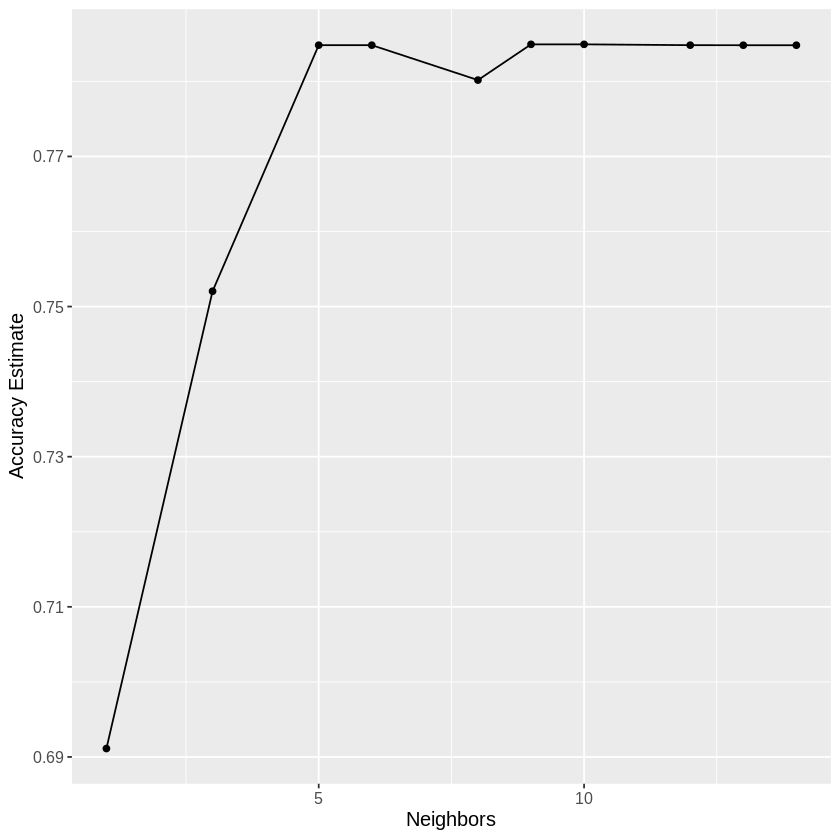

In [8]:
#Recipe, model, fit.
set.seed(11)

heart_recipe  <- recipe(diagnosis ~ ., data = heart_train)                  %>%
                 step_scale(all_predictors())                               %>%
                 step_center(all_predictors())

heart_vfold   <- vfold_cv(heart_train, v = 5, strata = diagnosis)

knn_spec      <- nearest_neighbor(weight_func = "rectangular", 
                                  neighbors   = tune())                     %>%
                 set_engine("kknn")                                         %>%
                 set_mode("classification")

heart_results <- workflow()                                                 %>%
                 add_recipe(heart_recipe)                                   %>%
                 add_model(knn_spec)                                        %>%
                 tune_grid(resamples = heart_vfold, grid = 10)              %>%
                 collect_metrics()

accuracy      <- heart_results                                              %>%
                 filter(.metric == "accuracy")

accuracy_plot <- ggplot(accuracy, aes(x = neighbors, y = mean))             +
                  geom_point()                                              +
                  geom_line()                                               +
                  labs(x = "Neighbors", y = "Accuracy Estimate")            + 
                  theme(text = element_text(size = 12))

accuracy_plot

In [9]:
set.seed(11)

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5)  %>%
              set_engine("kknn")                                            %>%
              set_mode("classification")

heart_fit  <- workflow()                                                    %>%
              add_recipe(heart_recipe)                                      %>%
              add_model(heart_spec)                                         %>%
              fit(data = heart_train)


heart_predictions <- predict(heart_fit, heart_test)                         %>%
                     bind_cols(heart_test)

heart_metrics     <- heart_predictions                                      %>%
                     metrics(truth = diagnosis, estimate = .pred_class)     %>%
                     filter(.metric == "accuracy")

heart_conf_mat    <- heart_predictions                                      %>%
                     conf_mat(truth = diagnosis, estimate = .pred_class)

number_accuracy   <- heart_predictions                                      %>%
                     metrics(truth = diagnosis, estimate = .pred_class)     %>%
                     filter(.metric == "accuracy")

heart_conf_mat
number_accuracy

          Truth
Prediction  0  1
         0 40 11
         1  8 30

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7865169
